In [1]:
from tensorflow import keras
import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from time import time
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

In [2]:
def append_ext(fn):
    return fn + ".jpg"

#loading dataset 
df = pd.read_csv("dataset.csv")

df["img"] = df["img"].apply(append_ext)

df = df.replace(np.nan, 0)

columns = ['gummy','golden_proportion ','gap','crowding','incisal embrassure ','color','Central line','Crooked','Central Incisor W/H Ratio','Black triangle','perfect']



In [3]:
#shuffle dataframe before splitting 
df=df.sample(frac=1).reset_index(drop=True)

In [4]:
# preprocessing the training set
train_data_generation = ImageDataGenerator(rescale=1./255)

training_set = train_data_generation.flow_from_dataframe(dataframe=df[:155],
                                                         directory="./cropped_teeth",
                                                         x_col="img",
                                                         y_col=columns,
                                                         target_size=(224, 224),
                                                         batch_size=8,
                                                         class_mode="raw",seed=0)

# preprocessing the testing set
valid_data_generation = ImageDataGenerator(rescale=1./255)

valid_set = valid_data_generation.flow_from_dataframe(dataframe=df[155:175],
                                                         directory="./cropped_teeth",
                                                         x_col="img",
                                                         y_col=columns,
                                                         target_size=(224, 224),
                                                         batch_size=8,
                                                         class_mode="raw",seed=0)

# preprocessing the testing set
test_data_generation = ImageDataGenerator(rescale=1./255)

test_set = test_data_generation.flow_from_dataframe(dataframe=df[175:],
                                                         directory="./cropped_teeth",
                                                         x_col="img",
                                                         y_col=None,
                                                         target_size=(224, 224),
                                                         batch_size=1,
                                                         class_mode=None,seed=0)

Found 155 validated image filenames.
Found 20 validated image filenames.
Found 19 validated image filenames.


In [5]:
# example of tending the vgg16 model
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

# load model without classifier layers
model = VGG16(include_top=False, input_shape=(224, 224, 3),weights='imagenet')
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)

output = Dense(11, activation='sigmoid')(flat1)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, mode='auto')
early = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, mode='auto')

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss = 'BinaryCrossentropy',metrics=['accuracy'])

history=model.fit(x=training_set, validation_data=valid_set, epochs=20, shuffle =True)
model.save("model_imagenet.h5")

Epoch 1/20
20/20 [==============================] - 26s 1s/step - loss: 0.1277 - accuracy: 0.3419 - val_loss: 0.5953 - val_accuracy: 0.1500
Epoch 2/20
20/20 [==============================] - 30s 2s/step - loss: 0.0890 - accuracy: 0.3419 - val_loss: 0.5806 - val_accuracy: 0.1500
Epoch 3/20
20/20 [==============================] - 27s 1s/step - loss: 0.0712 - accuracy: 0.3032 - val_loss: 0.5924 - val_accuracy: 0.1500
Epoch 4/20
20/20 [==============================] - 27s 1s/step - loss: 0.0662 - accuracy: 0.3806 - val_loss: 0.6011 - val_accuracy: 0.2500
Epoch 5/20
20/20 [==============================] - 27s 1s/step - loss: 0.0576 - accuracy: 0.4129 - val_loss: 0.6304 - val_accuracy: 0.1500
Epoch 6/20
20/20 [==============================] - 28s 1s/step - loss: 0.0519 - accuracy: 0.3032 - val_loss: 0.5659 - val_accuracy: 0.2000
Epoch 7/20
20/20 [==============================] - 28s 1s/step - loss: 0.0460 - accuracy: 0.3161 - val_loss: 0.5706 - val_accuracy: 0.1500
Epoch 8/20
20/20 [==

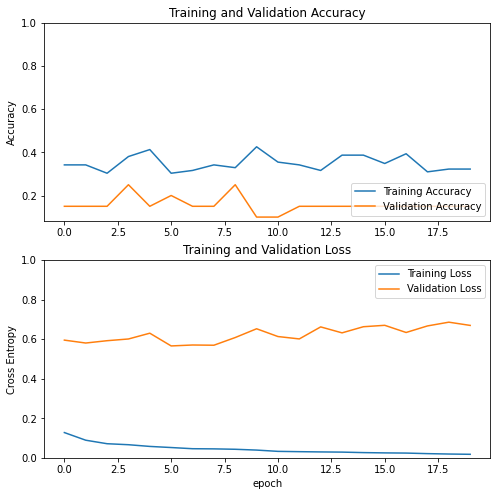

In [8]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [12]:
predictions= model.predict(test_set)
y=[]
print("10 Sample predictions:")
for pred in predictions:

  pred[pred>0.5]=1
  pred[pred<=0.65]=0
pd.DataFrame(predictions)

10 Sample predictions:


,0,1,2,3,4,5,6,7,8,9,10
0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
6,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
7,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
